In [ ]:
"""

Notebook instructions:
    
    1. Open notebook in the same directory as the lang_data.csv file provided and ensure a subdirectory 'models' has been created.
    2. Run the libraries window and ensure the necessary libraries are installed and successfully loaded.
        -> if the libraries are not installed use cmd terminal with: pip install *library name* or use the jupyter cell 
            with: !pip install *library name*
    3. Execute all cells to create the training/test dataset, train the model and finally export the model.
    4. This notebook is just to gain additional application experience
    
    NOTE: This notebook has been inspired from the origional author Łukasz Kamieniecki - Mruk and his origional work can be found here:
        -> http://machinelearningexp.com/deep-learning-language-identification-using-keras-tensorflow/

    
"""

In [1]:
# import the necessary libraries

import re
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers


C:\Users\haver\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# import the data into pandas pd
data_df = pd.read_csv('lang_data.csv')

# convert 'text' column to string
data_df['text'] = data_df['text'].astype(str)

# show the size of the matrix and provide a brief description
print("This dataset has %d observations and %d columns containing the instance example and its predictor." %(data_df.shape[0],data_df.shape[1]))
print("There are %d distinct language categories: %s, %s and %s" %(len(data_df['language'].unique()),data_df['language'].unique()[0],data_df['language'].unique()[1],data_df['language'].unique()[2]))

# show the first 5 observations of the dataset
data_df.head()

This dataset has 2839 observations and 2 columns containing the instance example and its predictor.
There are 3 distinct language categories: English, Afrikaans and Nederlands


,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [3]:
print(len(data_df[data_df['language'] == 'English']))
print(len(data_df[data_df['language'] == 'Afrikaans']))
print(len(data_df[data_df['language'] == 'Nederlands']))

2077
671
91


Significant class imbalance which will compromise prediction performance if not addressed.

In [4]:
# define methods to clean text used in test/training & any language predictions

# remove any empty lines
def remove_newlines(text):
    return text.replace(r"\n" , " ")

# remove any numbers from the data
def remove_numbers(text):
    return re.sub(r"^\d+\s|\s\d+\s|\s\d+$" , " " , text)

# remove any 'nan' as previously seen in the dataset
def remove_nan(text):
    return text.replace(r"nan", " ")

# remove appostrophies first and replace with an empty string
def remove_appostrophies(text):
    return re.sub(r"'","",text)

# remove other punctuation
def remove_punctuation(text):
    return re.sub(r"[^\w\s]"," ",text)

# remove many spaces from the data
def remove_duplicatespaces(text):
    return re.sub(r"\s+", " ", text)

# combine these operators all in a single method
def clean_text(text):
    
    text = remove_newlines(text)
    text= remove_numbers(text)
    text = remove_nan(text)
    text = remove_appostrophies(text)
    text = remove_punctuation(text)
    text = remove_duplicatespaces(text)
    
    return text

In [5]:
# duplicate data contained in a string of text to pad out to a specified length
def repeat_to_length(string_to_expand, length):
    return (string_to_expand * (int(length/len(string_to_expand))+1))[:length]

# extract the data from a pandas df and export to dictionary 
def data_category_combiner(data_df):
    
    english_data = []
    afrikaans_data = []
    nederlands_data = []
    
    for index, row in data_df.iterrows():
        
        if row['language'] == 'English':
            sample_text = row['text']
            english_data.append(sample_text)
            
        if row['language'] == 'Afrikaans':
            sample_text = row['text']
            afrikaans_data.append(sample_text)
            
        if row['language'] == 'Nederlands':
            sample_text = row['text']
            nederlands_data.append(sample_text)
    
    english_data = ','.join(english_data)
    english_data = repeat_to_length(english_data, 400000)
    english_data = clean_text(english_data)
    
    afrikaans_data = ','.join(afrikaans_data)
    afrikaans_data = repeat_to_length(afrikaans_data, 400000)
    afrikaans_data = clean_text(afrikaans_data)
    
    nederlands_data = ','.join(nederlands_data)
    nederlands_data = repeat_to_length(nederlands_data, 400000)
    nederlands_data = clean_text(nederlands_data)
    
    data_dict = { 0 : english_data, 1 : afrikaans_data, 2 : nederlands_data}
    
    return data_dict
    
data_dict = data_category_combiner(data_df)

In [6]:
# define an alphabet of characters to support the count operation of a given string
def define_alphabet():
    
    base_en = 'abcdefghijklmnopqrstuvwxyz'
    german = 'äöüß'
    italian = 'àèéìíòóùú'
    french = 'àâæçéèêêîïôœùûüÿ'
    spanish = 'áéíóúüñ'
    czech = 'áčďéěíjňóřšťúůýž'
    slovak = 'áäčďdzdžéíĺľňóôŕšťúýž'
    all_lang_chars = base_en + german +  italian + french + spanish + czech + slovak
    small_chars = list(set(list(all_lang_chars)))
    small_chars.sort() 
    big_chars = list(set(list(all_lang_chars.upper())))
    big_chars.sort()
    letters_string = ''
    letters = small_chars + big_chars
    for letter in letters:
        letters_string += letter
        
    return small_chars,big_chars,letters_string

alphabet = define_alphabet()
print(alphabet)

(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž'], 'abcdefghijklmnopqrstuvwxyzßàáâäæçèéêìíîïñòóôöùúûüýÿčďěĺľňœŕřšťůžABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÂÄÆÇÈÉÊÌÍÎÏÑÒÓÔÖÙÚÛÜÝČĎĚĹĽŇŒŔŘŠŤŮŸŽ')


In [7]:
# define the length of the text sample size to be extracted from the data dictionary items
text_sample_size = 140

# define the number of samples to be extracted from the data dictionary items for model training/validation
num_lang_samples = 400

languages_dict = { 0 : 'en', 1 :'afr', 2 : 'ned'}

# method to determine language given language_id from languages_dict
def decode_langid(lang_id):    
    for language, language_id in languages_dict.items():
        if language_id == lang_id:
            return language
        
# method to pull out a text sample        
def get_sample_text(file_content,start_index,sample_size):
    
    while not (file_content[start_index].isspace()):
        start_index += 1
    while file_content[start_index].isspace():
        start_index += 1
    end_index = start_index + sample_size 
    while not (file_content[end_index].isspace()):
        end_index -= 1
        
    return file_content[start_index:end_index]

In [8]:
# method to determine the count of characters given a string of text and the alphabet over which to iterate over
def count_chars(text,alphabet):
    
    alphabet_counts = []
    for letter in alphabet:
        count = text.count(letter)
        alphabet_counts.append(count)
        
    return alphabet_counts

# populate an array of counts across the small and big letter alphabets
def get_input_row(content,start_index,sample_size):
    
    sample_text = get_sample_text(content,start_index,sample_size)
    counted_chars_all = count_chars(sample_text.lower(),alphabet[0])
    counted_chars_big = count_chars(sample_text,alphabet[1])
    all_parts = counted_chars_all + counted_chars_big
    
    return all_parts

In [9]:
# illustrate an example string pulled from the data dictionary and the array representing the count of characters defined by the alphabet
random_index = random.randrange(0,text_sample_size)
sample_text = get_sample_text(data_dict[0],random_index,text_sample_size)
print ("1. Sample text: \n",clean_text(sample_text))
print("")
print ("2. Reference alphabet: \n",alphabet[0],alphabet[1])
print("")
sample_input_row = get_input_row(data_dict[0],random_index,text_sample_size)
print ("3. Sample character count: \n",sample_input_row)
print("\nDone.")

1. Sample text: 
 When the shit hits the fan Egg on Drag race As queer as a nine bob note Run the gauntlet Raining cats and dogs No laughing matter Run of the

2. Reference alphabet: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž'] ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž']

3. Sample character count: 
 [12, 2, 2, 3, 13, 2, 8, 8, 6, 0, 0, 2, 1, 14, 6, 0, 1, 7, 6, 12, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
# create an empty numpy array of size 1200 by 128
input_size = len(sample_input_row)
sample_data = np.empty((num_lang_samples*len(languages_dict),input_size+1),dtype = np.uint16)

lang_seq = 0

# populate the numpy array with character count observations representing strings of text for the 3 categories 
for lang_code in languages_dict:
    print("Processing language: ", languages_dict[lang_code] )
    start_index = 0
    file_content = data_dict[lang_code]
    content_length = len(file_content)
    remaining = content_length - text_sample_size*num_lang_samples
    jump = int(((remaining/num_lang_samples)*3)/4)
    print ("Number of characters in this file:" , content_length , " | # possible samples : ", int(content_length/input_size))
    for idx in range(num_lang_samples):
        input_row = get_input_row(file_content,start_index,text_sample_size)
        sample_data[num_lang_samples*lang_seq+idx] = input_row + [lang_code]
        start_index += text_sample_size
    del file_content
    lang_seq += 1

print("\nDone.")
    
# shuffle the category observations
np.random.shuffle(sample_data)


Processing language:  en
Number of characters in this file: 391575  | # possible samples :  3083
Processing language:  afr
Number of characters in this file: 382741  | # possible samples :  3013
Processing language:  ned
Number of characters in this file: 368225  | # possible samples :  2899

Done.


In [11]:
languages_dict = {'en':0,'afr':1,'ned':2}

# convert the numpy sample_data array to float
sample_data = sample_data.astype(np.float64)

# X and Y split
X = sample_data[:,0:input_size]
Y = sample_data[:,input_size]

# random index to check random sample
random_index = random.randrange(0,X.shape[0])
print("Example data before standardizing:")
print("\nX : \n", X[random_index,])
print("\nY : \n", Y[random_index])


# X preprocessing
# use standard scaler to scale the X predictor matrix
standard_scaler = preprocessing.StandardScaler().fit(X)
X = standard_scaler.transform(X)   

print("")
print("-"*100)
print("")

# convert category from 0.0 ,1.0 ,2.0 to [1. 0. 0.], [0. 1. 0.] and [0. 0. 1.]
Y = keras.utils.to_categorical(Y, num_classes=len(languages_dict))

# see an example before and after the scaling and one-hot encoding
print("Example data after standardizing:")
print("\nX : \n", X[random_index,])
print("\nY : \n", Y[random_index])

# split the data into training and test sets with a specific seed for model duplicity
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)
print("\nDone.")


Example data before standardizing:

X : 
 [14.  0.  0.  5. 27.  0.  6.  1.  4.  1.  7.  7.  4. 15.  1.  1.  0.  3.
  3.  5.  0.  1.  1.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]

Y : 
 2.0

----------------------------------------------------------------------------------------------------

Example data after standardizing:

X : 
 [ 1.72718329 -1.41579972 -0.77708501 -0.20630558  1.6490092  -0.78813398
  1.33959394 -1.14000242 -1.29861948 -0.16887511  1.87180607  1.03858995
  0.78682163  1.96027923 -2.10580891 -0.57482152 -0.1935107  -1.15067333
 -1.12974602 -0.95441149 -1.5891211  -0.33061175 -0.78456171 -0.195

In [12]:
# instantiate a model instance and add layers to the neural network
model = Sequential()
model.add(Dense(500,input_dim=input_size,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(languages_dict),kernel_initializer="glorot_uniform",activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# compile the elements of the the neural network
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])


In [13]:
# train the compiled model on the training data with a train/validation split of 
history = model.fit(X_train,Y_train,
          epochs=12,
          validation_split=0.10,
          batch_size=64,
          verbose=2,
          shuffle=True)

Train on 864 samples, validate on 96 samples
Epoch 1/12
 - 1s - loss: 1.2819 - acc: 0.3438 - val_loss: 1.1122 - val_acc: 0.6146
Epoch 2/12
 - 0s - loss: 1.1978 - acc: 0.3623 - val_loss: 0.9883 - val_acc: 0.3646
Epoch 3/12
 - 0s - loss: 1.0387 - acc: 0.4433 - val_loss: 0.8919 - val_acc: 0.6354
Epoch 4/12
 - 0s - loss: 0.8952 - acc: 0.5845 - val_loss: 0.6403 - val_acc: 0.9583
Epoch 5/12
 - 0s - loss: 0.6902 - acc: 0.7025 - val_loss: 0.4191 - val_acc: 0.9167
Epoch 6/12
 - 0s - loss: 0.4740 - acc: 0.8299 - val_loss: 0.2724 - val_acc: 0.9688
Epoch 7/12
 - 0s - loss: 0.3027 - acc: 0.9155 - val_loss: 0.1637 - val_acc: 0.9688
Epoch 8/12
 - 0s - loss: 0.2250 - acc: 0.9363 - val_loss: 0.1005 - val_acc: 0.9792
Epoch 9/12
 - 0s - loss: 0.1515 - acc: 0.9595 - val_loss: 0.0717 - val_acc: 0.9792
Epoch 10/12
 - 0s - loss: 0.1074 - acc: 0.9792 - val_loss: 0.0467 - val_acc: 1.0000
Epoch 11/12
 - 0s - loss: 0.0857 - acc: 0.9838 - val_loss: 0.0392 - val_acc: 1.0000
Epoch 12/12
 - 0s - loss: 0.0656 - acc: 

In [14]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

240/240 [==============================] - 0s 113us/step
acc: 98.75%


In [15]:
# prepare the data for scikit-learn classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(languages_dict))

# call the classification report class
target_names =  list(languages_dict.keys())
print(classification_report(Y_test, Y_pred, target_names=target_names))


             precision    recall  f1-score   support

         en       1.00      0.99      0.99        75
        afr       0.99      0.98      0.98        82
        ned       0.98      1.00      0.99        83

avg / total       0.99      0.99      0.99       240



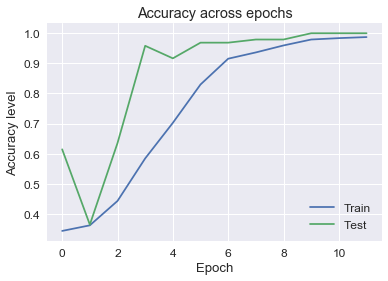

In [16]:
# show plot accuracy changes during training using seaborn
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy across epochs')
plt.ylabel('Accuracy level')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

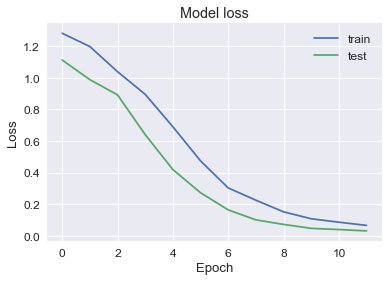

In [17]:
# show plot of loss changes during training
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

In [18]:
# method to test a given string and return the trained model prediction

en_text = "Looking for the meanings of words, phrases, and expressions? We provide hundreds of thousands of definitions, synonyms, antonyms, and pronunciations for English and other languages, derived from our language research and expert analysis. We also offer a unique set of examples of real usage, as well as guides to"
afr_text = "Verskeie organisasies en individue met ’n liefde en passie vir Afrikaans het saamgekom om Afrikaans in haar verskillende vorme te vier en te verken. Ons nooi jou saam op hierdie ontdekkingstog die wye Afrikaanse landskap in. Ons vra mede-avontuurlustiges om jul unieke Afrikaanse leefwêrelde met ons te deel en ons te verras met jul uitkyk op en ervaring van Afrikaans."
ned_text = "Alle mensen worden vrij en gelijk in waardigheid en rechten geboren. Zij zijn begiftigd met verstand en geweten, en behoren zich jegens elkander in een geest van broederschap te gedragen."


text_texts_array = [en_text, afr_text, ned_text]
test_array = []
for item in text_texts_array:
    cleaned_text = clean_text(item)
    input_row = get_input_row(cleaned_text,0,text_sample_size)
    test_array.append(input_row)

test_array = standard_scaler.transform(test_array)     
Y_pred = model.predict_classes(test_array)
for id in range(len(test_array)):
    print ("Text:",text_texts_array[id][:50],"... -> Predicted lang: ", decode_langid(Y_pred[id]))

Text: Looking for the meanings of words, phrases, and ex ... -> Predicted lang:  en
Text: Verskeie organisasies en individue met ’n liefde e ... -> Predicted lang:  afr
Text: Alle mensen worden vrij en gelijk in waardigheid e ... -> Predicted lang:  ned


In [19]:
# function to receive a text string from a user and classify the predicted language
def return_prediction():
    
    example_string=input() 
    minimum_string_length = 140
    
    try:
        assert len(example_string) > minimum_string_length
        cleaned_text = clean_text(example_string)
        text_texts_array = [example_string]
        test_array = []
        for item in text_texts_array:
            cleaned_text = clean_text(item)
            input_row = get_input_row(cleaned_text,0,text_sample_size)
            test_array.append(input_row)
        test_array = standard_scaler.transform(test_array)
        Y_pred = model.predict_classes(test_array)
        print ("\nText example snippet:", example_string[:50] , "... -> Predicted lang: ", decode_langid(Y_pred))
    
    except AssertionError:
        print ('\nProgram Error: Please provide phrase longer than %d characters for classification.'  %(minimum_string_length))
        exit(1)
    
return_prediction()

Een van de meest bekende schepen die tot de 17e eeuwse maritieme macht van de Verenigde Oost-Indische Compagnie behoorde, is het jacht de Sperwer geweest. Vaartuigen van de V.O.C. bleken zo vaak niet bestand tegen de stormen die in de gevaarlijke zeeën van Oost-Azië voorkwamen, dat het buiten de kring van de belanghebbenden amper bekend is geworden dat dit jacht in 1653 op zijn reis van Taiwan naar Japan de haven van bestemming niet bereikte.

Text example snippet: Een van de meest bekende schepen die tot de 17e ee ... -> Predicted lang:  ned


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model/model.h5")
print("Saved model to disk")